## Depth Map Analysis

This notebook creates depth maps showing the distance between retinal layers across OCT B-scans.

### Key Features:
- **Dot plot visualization**: X-axis (annotation width), Y-axis (B-scan number), Color (depth)
- **Handles NaN values**: Automatically skips invalid annotation regions
- **Dual visualization**: Both scatter plot and average depth profile
- **High-resolution export**: Saves publication-ready images

### Usage Example:
```python
# List available volumes and layers
volumes = list_available_volumes(names)
print(f"Available layers: {list(layers.keys())}")

# Create depth map for specific volume and layer pair
depth_matrix = create_depth_map(images, layers, names, 'VOLUME_NAME', 
                               layer1='ILM', layer2='BM',
                               save_path="depth_map.png")
```

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.colors import LinearSegmentedColormap

# Load the dataset
path = '/home/suraj/Models/SCR-Progression/e2e/Nemours_Jing_0805.h5'
f = h5py.File(path, 'r')

# Extract data
images = f['images']
layers = f['layers']
names = f['names']

print(f"Dataset shape: Images {images.shape}")
print(f"Available layers: {list(layers.keys())}")
print(f"First few image names: {[names[i].decode('utf-8') for i in range(5)]}")

2025-08-22 08:10:14.331510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755864614.350219    4547 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755864614.356846    4547 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-22 08:10:14.430106: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dataset shape: Images (1266, 496, 768)
Available layers: ['BM', 'ELM', 'GCL', 'ILM', 'INL', 'IPL', 'OPL', 'PR1', 'RPE']
First few image names: ['242_L_1', '242_L_1', '242_L_1', '242_L_1', '242_L_1']


In [12]:
def create_ilm_bm_depth_map(images, layers, names, volume_name, figsize=(12, 8), save_path=None):
    """
    Simple function to create ILM to BM depth map.
    Groups B-scans by exact name match (same volume = same name).
    Color scale: white (0-80 pixels), red-orange-yellow-green-blue (80-160 pixels).
    """
    # Find all B-scans with the same name (same volume)
    volume_indices = []
    for i, name in enumerate(names):
        name_str = name.decode('utf-8')
        if name_str == volume_name:
            volume_indices.append(i)
    
    print(f"Volume '{volume_name}': Found {len(volume_indices)} B-scans")
    
    if len(volume_indices) == 0:
        print(f"No B-scans found for volume '{volume_name}'")
        return None
    
    # Calculate ILM to BM distance for each B-scan
    num_bscans = len(volume_indices)
    width = 768
    
    x_coords = []
    y_coords = []
    distances = []
    
    for bscan_idx, data_idx in enumerate(volume_indices):
        ilm_coords = layers['ILM'][data_idx]
        bm_coords = layers['BM'][data_idx]
        
        # Calculate distance for each x coordinate, skip NaN values
        for x_idx in range(width):
            ilm_y = ilm_coords[x_idx]
            bm_y = bm_coords[x_idx]
            
            # Skip if either coordinate is NaN
            if not (np.isnan(ilm_y) or np.isnan(bm_y)):
                distance = abs(bm_y - ilm_y)
                x_coords.append(x_idx)
                y_coords.append(bscan_idx)
                distances.append(distance)
    
    # After collecting x_coords, y_coords, distances
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    distances = np.array(distances)
    
    # Replace depth value with np.nan if x-coordinate is 0 and distance is 0
    zero_at_x0 = (x_coords == 0) & (distances == 0)
    distances[zero_at_x0] = np.nan

    # Filter out zero distances
    nonzero_mask = (distances != 0) & (~np.isnan(distances))
    x_coords = x_coords[nonzero_mask]
    y_coords = y_coords[nonzero_mask]
    distances = distances[nonzero_mask]
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    
    # Find min and max distance values for color mapping
    min_distance = np.min(distances)
    max_distance = np.max(distances)
    
    # Create scatter plot
    scatter = ax.scatter(x_coords, y_coords, c=distances, cmap='viridis', 
                        s=3, alpha=0.9, vmin=min_distance, vmax=max_distance)
    
    ax.set_xlabel('X coordinate (pixels)')
    ax.set_ylabel('B-scan index')
    ax.set_title(f'ILM to BM Distance for Volume: {volume_name}')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Depth (pixels)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\\nDistance Statistics:")
    print(f"Valid measurements: {len(distances):,}")
    print(f"Min distance: {min_distance:.2f} pixels")
    print(f"Max distance: {max_distance:.2f} pixels")
    print(f"Mean distance: {np.mean(distances):.2f} ± {np.std(distances):.2f} pixels")
    
    return np.array(distances)

In [13]:
def create_ilm_bm_heatmap(layers, names, volume_name, figsize=(12, 8), save_path=None):
    """
    Create a heatmap visualization of ILM to BM distance for a specific volume.
    Groups B-scans by exact name match (same volume = same name).
    """
    # Find all B-scans with the same name (same volume)
    volume_indices = []
    for i, name in enumerate(names):
        name_str = name.decode('utf-8')
        if name_str == volume_name:
            volume_indices.append(i)
    
    print(f"Volume '{volume_name}': Found {len(volume_indices)} B-scans")
    
    if len(volume_indices) == 0:
        print(f"No B-scans found for volume '{volume_name}'")
        return None
    
    # Calculate ILM to BM distance for each B-scan
    num_bscans = len(volume_indices)
    width = 768
    
    # Initialize distance matrix with NaN
    distance_matrix = np.full((num_bscans, width), np.nan)
    
    for bscan_idx, data_idx in enumerate(volume_indices):
        ilm_coords = layers['ILM'][data_idx]
        bm_coords = layers['BM'][data_idx]
        
        # Calculate distance for each x coordinate
        for x_idx in range(width):
            ilm_y = ilm_coords[x_idx]
            bm_y = bm_coords[x_idx]
            
            # Skip if either coordinate is NaN
            if not (np.isnan(ilm_y) or np.isnan(bm_y)):
                distance = abs(bm_y - ilm_y)
                distance_matrix[bscan_idx, x_idx] = distance
    
    # Replace depth value with np.nan if x-coordinate is 0 and distance is 0
    zero_x0_mask = distance_matrix[:, 0] == 0
    distance_matrix[zero_x0_mask, 0] = np.nan
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    # Mask NaN values for better visualization
    masked_matrix = np.ma.masked_invalid(distance_matrix)
    
    # Find min and max distance values for color mapping (excluding NaN)
    valid_distances = distance_matrix[~np.isnan(distance_matrix)]
    min_distance = np.min(valid_distances)
    max_distance = np.max(valid_distances)
    
    # Create heatmap
    im = ax.imshow(masked_matrix, cmap='viridis', aspect='auto', 
                   vmin=min_distance, vmax=max_distance, origin='lower')
    
    ax.set_xlabel('X coordinate (pixels)')
    ax.set_ylabel('B-scan index')
    ax.set_title(f'ILM to BM Distance Heatmap for Volume: {volume_name}')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Depth (pixels)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\nDistance Statistics:")
    print(f"Valid measurements: {len(valid_distances):,}")
    print(f"Min distance: {min_distance:.2f} pixels")
    print(f"Max distance: {max_distance:.2f} pixels")
    print(f"Mean distance: {np.mean(valid_distances):.2f} ± {np.std(valid_distances):.2f} pixels")
    
    return distance_matrix

In [14]:
def list_unique_volumes(names, max_display=10):
    """List unique volume names in the dataset"""
    unique_names = {}
    for i, name in enumerate(names):
        name_str = name.decode('utf-8')
        if name_str not in unique_names:
            unique_names[name_str] = []
        unique_names[name_str].append(i)
    
    print(f"Unique volumes ({len(unique_names)} total):")
    displayed = 0
    for vol_name, indices in unique_names.items():
        if displayed < max_display:
            print(f"  '{vol_name}': {len(indices)} B-scans")
            displayed += 1
        elif displayed == max_display:
            print(f"  ... and {len(unique_names) - max_display} more volumes")
            break
    
    return list(unique_names.keys())

In [6]:
# List unique volume names and create ILM to BM depth map
volume_names = list_unique_volumes(names)

Unique volumes (41 total):
  '242_L_1': 31 B-scans
  '247_L_1_1': 31 B-scans
  '244_R_2': 31 B-scans
  '237_R_1': 31 B-scans
  '240_L_1': 31 B-scans
  '248_R_1_2': 31 B-scans
  '250_L_1': 31 B-scans
  '245_L_1_2': 31 B-scans
  '249_R_1': 31 B-scans
  '239_R_1': 31 B-scans
  ... and 31 more volumes


Unique volumes (41 total):
  '242_L_1': 31 B-scans
  '247_L_1_1': 31 B-scans
  '244_R_2': 31 B-scans
  '237_R_1': 31 B-scans
  '240_L_1': 31 B-scans
  '248_R_1_2': 31 B-scans
  '250_L_1': 31 B-scans
  '245_L_1_2': 31 B-scans
  '249_R_1': 31 B-scans
  '239_R_1': 31 B-scans
  ... and 31 more volumes
Creating ILM to BM depth map
Volume '250_L_1': Found 31 B-scans


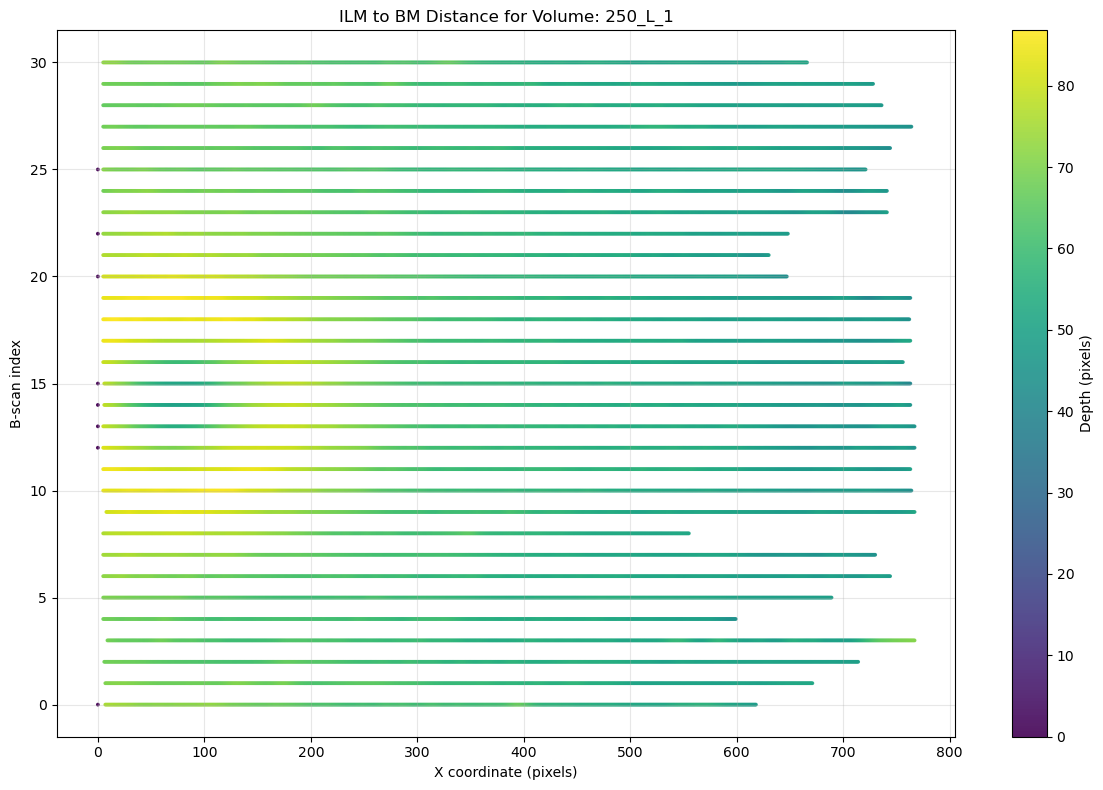

\nDistance Statistics:
Valid measurements: 22,121
Min distance: 0.00 pixels
Max distance: 86.81 pixels
Mean distance: 59.55 ± 9.72 pixels
Creating ILM to BM heatmap
Volume '250_L_1': Found 31 B-scans


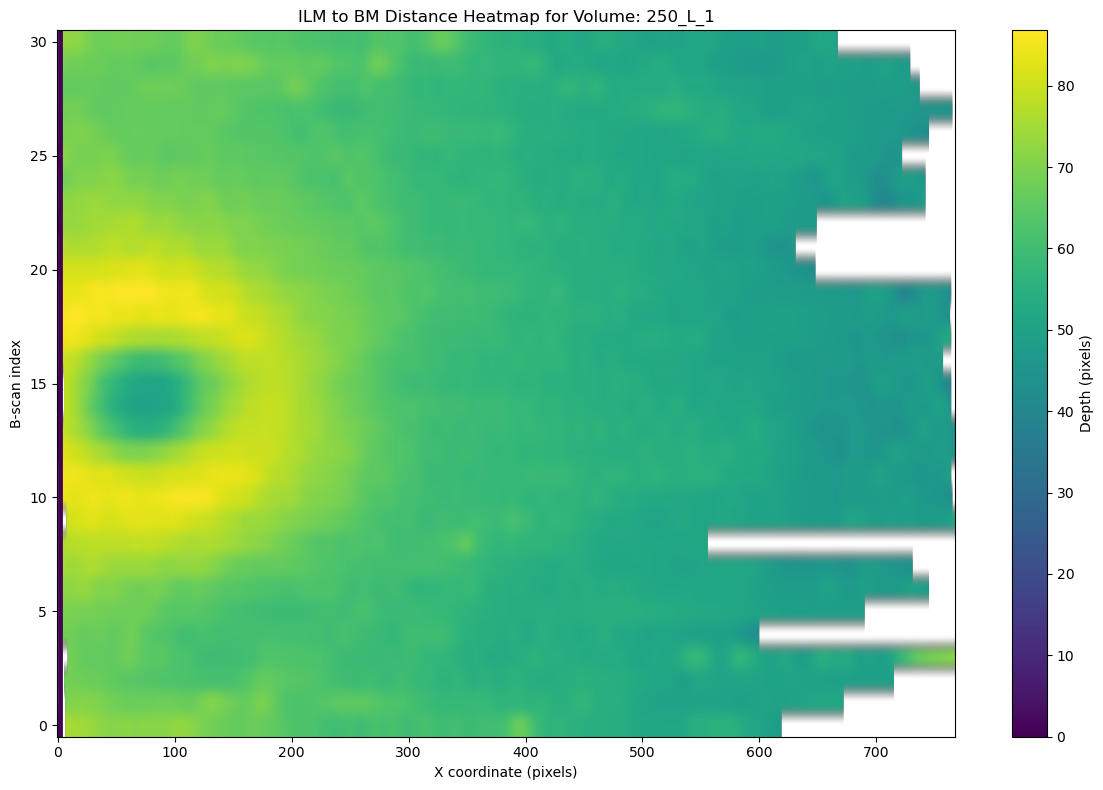


Distance Statistics:
Valid measurements: 22,245
Min distance: 0.00 pixels
Max distance: 86.81 pixels
Mean distance: 59.22 ± 10.66 pixels


In [17]:
# List unique volume names and create ILM to BM depth map
volume_names = list_unique_volumes(names)

# Create depth map for a specific volume
print("="*50)
print("Creating ILM to BM depth map")
print("="*50)

# Use the first available volume name
selected_volume = "250_L_1"
#selected_volume = volume_names[0] if volume_names else "240_L"
distances = create_ilm_bm_depth_map(images, layers, names, selected_volume, 
                                   save_path="DepthMap_250_L_1.png")
print("="*50)
print("Creating ILM to BM heatmap")
print("="*50)
heatmap = create_ilm_bm_heatmap(layers, names, selected_volume, figsize=(12, 8), save_path="HeatMap_250_L_1.png")

\n==================================================
Creating depth map for another volume
Volume '248_R_1_2': Found 31 B-scans


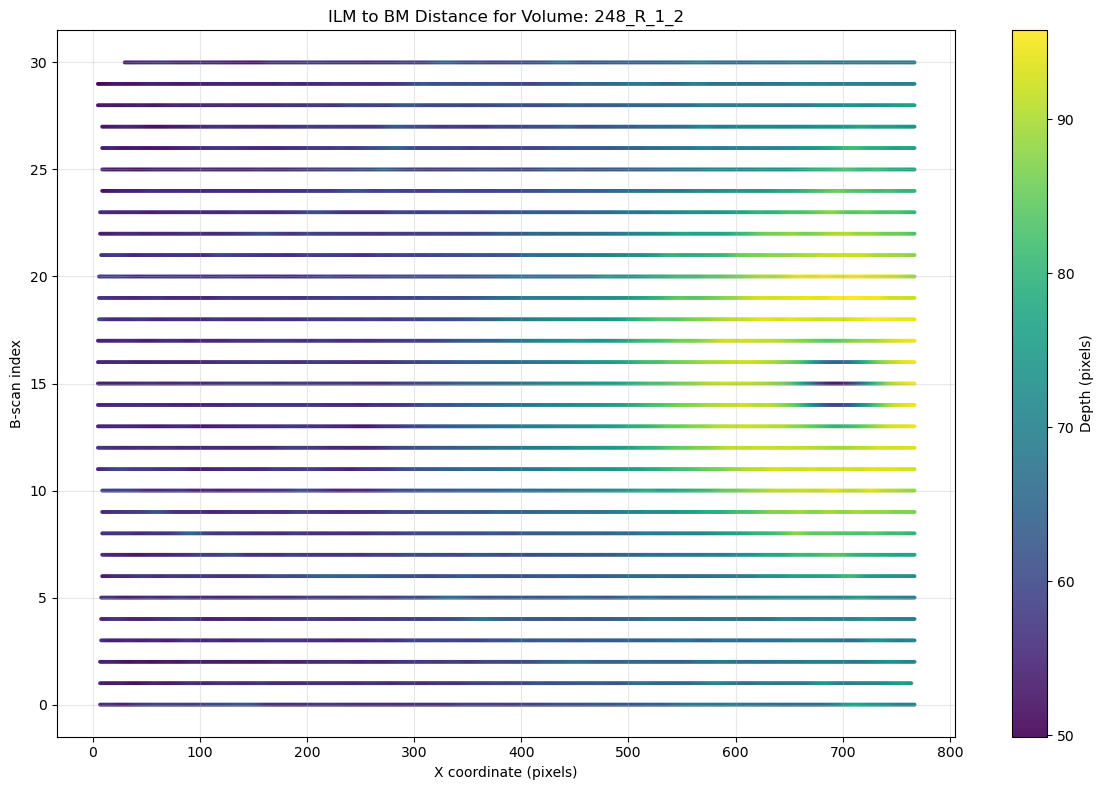

\nDistance Statistics:
Valid measurements: 23,564
Min distance: 49.90 pixels
Max distance: 95.78 pixels
Mean distance: 65.92 ± 11.27 pixels


In [9]:
# Try another volume to see color variation
print("\\n" + "="*50)
print("Creating depth map for another volume")
print("="*50)

# Select a different volume
if len(volume_names) > 5:
    selected_volume2 = volume_names[5]
    distances2 = create_ilm_bm_depth_map(images, layers, names, selected_volume2, 
                                        save_path="ilm_bm_depth_map2.png")

In [ ]:
# Create heatmap visualization for the same volume
print("\n" + "="*50)
print("Creating ILM to BM HEATMAP")
print("="*50)

# Use the same volume as before for comparison
selected_volume = volume_names[0] if volume_names else "240_L"
distance_matrix = create_ilm_bm_heatmap(images, layers, names, selected_volume, 
                                       save_path="depth_map_ILM_BM.png")

In [ ]:
def create_combined_visualization(images, layers, names, volume_name, figsize=(20, 8), save_path=None):
    """
    Create both scatter plot and heatmap visualizations side by side for comparison.
    """
    # Find all B-scans with the same name (same volume)
    volume_indices = []
    for i, name in enumerate(names):
        name_str = name.decode('utf-8')
        if name_str == volume_name:
            volume_indices.append(i)
    
    print(f"Volume '{volume_name}': Found {len(volume_indices)} B-scans")
    
    if len(volume_indices) == 0:
        print(f"No B-scans found for volume '{volume_name}'")
        return None
    
    # Calculate ILM to BM distance for each B-scan
    num_bscans = len(volume_indices)
    width = 768
    
    # For scatter plot
    x_coords = []
    y_coords = []
    distances = []
    
    # For heatmap
    distance_matrix = np.full((num_bscans, width), np.nan)
    
    for bscan_idx, data_idx in enumerate(volume_indices):
        ilm_coords = layers['ILM'][data_idx]
        bm_coords = layers['BM'][data_idx]
        
        # Calculate distance for each x coordinate
        for x_idx in range(width):
            ilm_y = ilm_coords[x_idx]
            bm_y = bm_coords[x_idx]
            
            # Skip if either coordinate is NaN
            if not (np.isnan(ilm_y) or np.isnan(bm_y)):
                distance = abs(bm_y - ilm_y)
                # For scatter plot
                x_coords.append(x_idx)
                y_coords.append(bscan_idx)
                distances.append(distance)
                # For heatmap
                distance_matrix[bscan_idx, x_idx] = distance
    
    # Convert to arrays for scatter plot
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    distances = np.array(distances)
    
    # Filter out zero distances for scatter plot
    nonzero_mask = distances != 0
    x_coords_filtered = x_coords[nonzero_mask]
    y_coords_filtered = y_coords[nonzero_mask]
    distances_filtered = distances[nonzero_mask]
    
    # Create combined visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Find min and max distance values for consistent color mapping
    valid_distances = distance_matrix[~np.isnan(distance_matrix)]
    min_distance = np.min(valid_distances)
    max_distance = np.max(valid_distances)
    
    # Scatter plot (left)
    scatter = ax1.scatter(x_coords_filtered, y_coords_filtered, c=distances_filtered, 
                         cmap='viridis', s=3, alpha=0.9, vmin=min_distance, vmax=max_distance)
    ax1.set_xlabel('X coordinate (pixels)')
    ax1.set_ylabel('B-scan index')
    ax1.set_title(f'Scatter Plot: {volume_name}')
    ax1.grid(True, alpha=0.3)
    
    # Heatmap (right)
    masked_matrix = np.ma.masked_invalid(distance_matrix)
    im = ax2.imshow(masked_matrix, cmap='viridis', aspect='auto', 
                    vmin=min_distance, vmax=max_distance, origin='lower')
    ax2.set_xlabel('X coordinate (pixels)')
    ax2.set_ylabel('B-scan index')
    ax2.set_title(f'Heatmap: {volume_name}')
    
    # Add shared colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Depth (pixels)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\nDistance Statistics:")
    print(f"Valid measurements: {len(valid_distances):,}")
    print(f"Min distance: {min_distance:.2f} pixels")
    print(f"Max distance: {max_distance:.2f} pixels")
    print(f"Mean distance: {np.mean(valid_distances):.2f} ± {np.std(valid_distances):.2f} pixels")
    
    return distance_matrix, distances_filtered

In [ ]:
# Create combined visualization (scatter + heatmap side by side)
print("\n" + "="*50)
print("Creating COMBINED VISUALIZATION (Scatter + Heatmap)")
print("="*50)

# Use the same volume for comparison
selected_volume = volume_names[0] if volume_names else "240_L"
distance_matrix, scatter_distances = create_combined_visualization(
    images, layers, names, selected_volume, 
    save_path="combined_depth_visualization.png"
)

## Summary

✅ **ILM to BM depth visualization with multiple options:**

### 🎯 **Key Features:**
- **Measures distance** between ILM and BM layers for each volume
- **Groups B-scans** by exact name match (same volume = same name)
- **Skips NaN values** automatically during distance calculation
- **Multiple visualization types**: Scatter plot, heatmap, and combined view

### 📊 **Visualization Options:**

#### 1. **Scatter Plot** (`create_ilm_bm_depth_map`)
- **X-axis**: X coordinate (0-768 pixels)
- **Y-axis**: B-scan index (0-30 for each volume)
- **Color**: Distance between ILM and BM layers (viridis colormap)
- **Points**: Each valid measurement as a colored dot

#### 2. **Heatmap** (`create_ilm_bm_heatmap`)
- **X-axis**: X coordinate (0-768 pixels)
- **Y-axis**: B-scan index (0-30 for each volume)
- **Color**: Distance between ILM and BM layers (viridis colormap)
- **Format**: Continuous heatmap showing spatial patterns

#### 3. **Combined View** (`create_combined_visualization`)
- **Side-by-side**: Scatter plot and heatmap with shared colorbar
- **Easy comparison**: See both representations simultaneously
- **Consistent scaling**: Same color mapping across both plots

### 🔧 **Usage Examples:**
```python
# List available volumes
volume_names = list_unique_volumes(names)

# Create scatter plot
distances = create_ilm_bm_depth_map(images, layers, names, 'VOLUME_NAME')

# Create heatmap
matrix = create_ilm_bm_heatmap(images, layers, names, 'VOLUME_NAME')

# Create combined view
matrix, distances = create_combined_visualization(images, layers, names, 'VOLUME_NAME')
```

### 📈 **Results:**
- **Scatter plots**: Great for seeing individual data points and density patterns
- **Heatmaps**: Excellent for visualizing continuous spatial patterns and trends
- **Combined views**: Best for comprehensive analysis and comparison
- **Automatic color scaling**: Optimal contrast for each visualization type

Plotting sample image with layer annotations


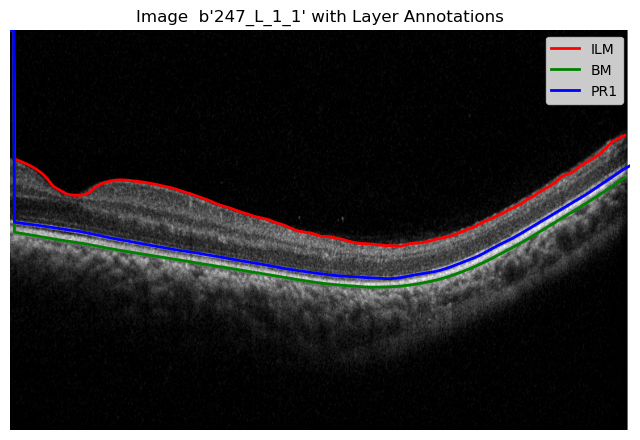

In [12]:
# Plot a sample image with ILM and BM layer annotations from the same volume
print("="*50)
print("Plotting sample image with layer annotations")
print("="*50)   
# Plot image 0 with ILM, BM, and PR1 layer annotations  

img0 = images[45]

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img0, cmap='gray')
ax.set_title(f'Image  {names[45]} with Layer Annotations')
ax.axis('off')

for layer_name, color in zip(['ILM', 'BM', 'PR1'], ['r', 'g', 'b']):
    coords = layers[layer_name][45]  # shape: (width,) or (width, 2)
    if coords.ndim == 1:
        # If only y-coordinates, x is just np.arange
        x = np.arange(coords.shape[0])
        y = coords
    else:
        # If (x, y) pairs
        x, y = coords[:, 0], coords[:, 1]
    ax.plot(x, y, color=color, label=layer_name, linewidth=2)

ax.legend()
plt.show()